## Many Objective Robust Decision Making (MORDM)
This notebook performs the MORDM. First the problem is formulated, next candidate solutions are searched using the optimize function. These candidate solutions are filtered based on our own criterea after which they are tested on robustness. Based on the robustness a final candidate solution is chosen.


### Step 1: Problem formulation
At first, some libraries are loaded and the problem formulation is called. For this, problem formulation 7 (general optimization) is used

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from ema_workbench import (Model, CategoricalParameter, ScalarOutcome, IntegerParameter, RealParameter)
from ema_workbench import (Model, MultiprocessingEvaluator, SequentialEvaluator, Policy, Scenario)
from dike_model_function import DikeNetwork 

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation

ema_logging.log_to_stderr(ema_logging.INFO)

#choose problem formulation number, between 0-7
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(7)

def sum_over(*args):
    return sum(args)

#Boolean for running model instances
runmodel = False

#Boolean for saving generated images
remakeimages = True

## Step 2: Searching for candidate solutions

Here, the optimize function is ran to search optimal solutions by varying the model levers. First the expected minimum and maximum values are specified as well as the epsilon values. To determine the maximum values, several random policies are ran from which the maximum was taken per outcome. The epsilons are set to a hundredth of the maximum value.

The results and convergence are saved in excel files and could therefore be loaded to reproduce these resutls.

In [2]:
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

#optimize numbers for Expected annual damage, expected numebr of deaths, Total investment costs and expected evacuation costs.
optimize_min = [0,0,0,0]
optimize_max = [5e9, 1 ,1e9, 1e7]
optimize_epsilon = [1e7,1e-2,1e7, 1e5]

convergence_metrics = [HyperVolume(minimum=optimize_min, maximum=optimize_max),
                       EpsilonProgress()]

if runmodel:
    with MultiprocessingEvaluator(dike_model) as evaluator: 
         results1, convergence = evaluator.optimize(nfe=15000, searchover='levers', epsilons=optimize_epsilon, 
                                                    convergence=convergence_metrics)
    results1.to_excel('./export/results_optimize_results.xlsx')
    convergence.to_excel('./export/results_optimize_convergence.xlsx')
else:
    results1 = pd.read_excel('./export/results_optimize_results.xlsx', index_col=0, )
    convergence = pd.read_excel('./export/results_optimize_convergence.xlsx', index_col=0, )

To check wheter the optimize function has converged, the epsilon progress and hypervolume are plotted

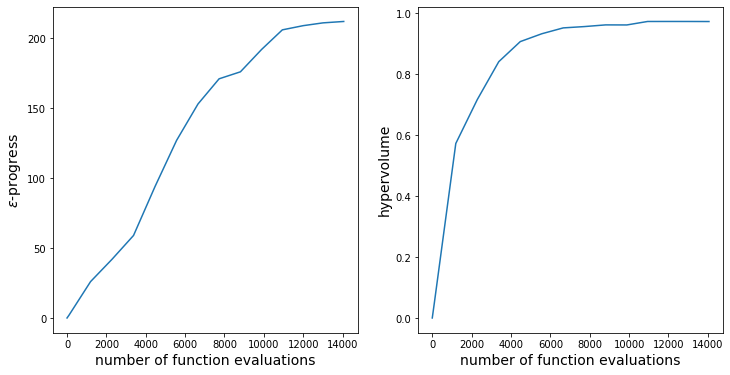

In [3]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(12,6))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress', fontsize=14)
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume', fontsize=14)

ax1.set_xlabel('number of function evaluations', fontsize=14)
ax2.set_xlabel('number of function evaluations', fontsize=14)

if remakeimages:
    extent_ax1 = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig('export/nfe_e-progress.png', bbox_inches=extent_ax1.expanded(1.25, 1.25))
    extent_ax2 = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig('export/nfe_hypervolume.png', bbox_inches=extent_ax2.expanded(1.25, 1.25))
    plt.savefig('export/nfe_combined.png')
    
plt.show()

**Interpretation:** Both the hypervolume and epsilon progress starts to converge. Based on the epsilon graph, more iterations could be performed to create more reliable results. Yet we continue to use the 16 policies which came out of the optimize function.

### Step 2.2 Run sollutions under KPI's Gelderland

The optimize functions is ran over problem formulation 7 (general optimization) yet we are especially interested in how these optimal policies score on our own KPI's. Therefore experiments are ran for all 16 policies for 200 scenarios. The number of scenario's is kept low because this run is only used to filter the policies. Hereafter the run will be extended to check robustness.

In [5]:
#First copy results and remove outcomes (leave just the policy)
results_optimize_copy = results1
policies_values = results_optimize_copy.drop(columns=['EAD', 'END', 'TIC', 'EEC'])
policies_general_optimize = policies_values
policies = []
for i, policy in policies_values.iterrows():
    policies.append(Policy(str(i), **policy.to_dict()))
    
dike_model, planning_steps = get_model_for_problem_formulation(6)

if runmodel:
    with MultiprocessingEvaluator(dike_model) as evaluator:
        resultsKPI = perform_experiments(dike_model, scenarios=200, policies=policies, evaluator=evaluator) 
        experiments, outcomes = resultsKPI
        outcomes_df = pd.DataFrame(outcomes)
        experiments.to_excel('./export/experiments_GelderKPI_experiments.xlsx')
        outcomes_df.to_excel('./export/experiments_GelderKPI_outcomes.xlsx')
else:
    experiments = pd.read_excel('./export/experiments_GelderKPI_experiments.xlsx', index_col=0, )
    outcomes_df = pd.read_excel('./export/experiments_GelderKPI_outcomes.xlsx', index_col=0, )

Next, we make a parcoords graph to examine the tradeoffs which must be made.

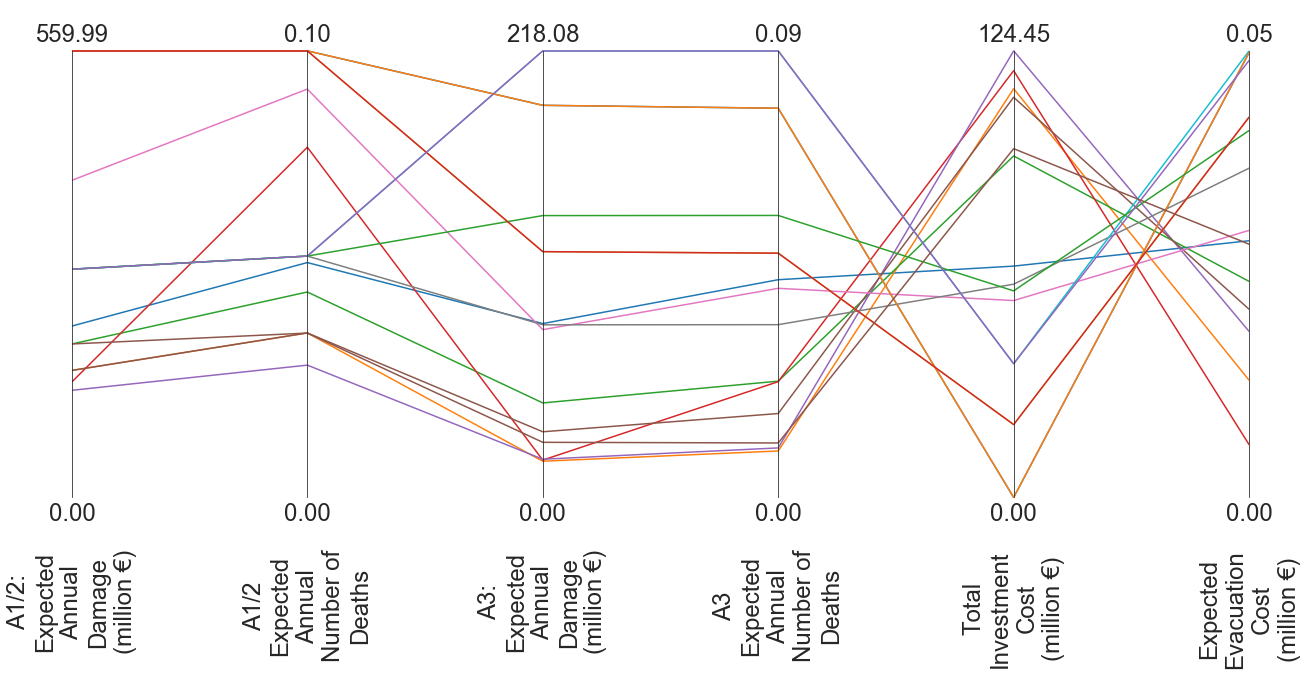

In [6]:
from ema_workbench.analysis import parcoords
from matplotlib.pyplot import figure

outcomes_mean = pd.DataFrame()
single_mean = {}

for policy in np.unique(experiments['policy']): #loop x times for x different unique policies
    logical = experiments['policy']==policy #series of true/false for policy iteration
    for key in outcomes_df.keys(): #loop x times for each key in outcomes
        single_mean[key] = np.mean(outcomes_df[key][logical])
    outcomes_mean = outcomes_mean.append(pd.DataFrame(single_mean, index = [policy]))

data = outcomes_mean
data['A1/2_EAD'] = data['A1/2_EAD'].apply(lambda x: x/1000000)
data['A3_EAD'] = data['A3_EAD'].apply(lambda x: x/1000000)
data['G_TIC'] = data['G_TIC'].apply(lambda x: x/1000000)
data['EEC'] = data['EEC'].apply(lambda x: x/1000000)

data.rename(columns={'A1/2_EAD':'A1/2:\nExpected\nAnnual\nDamage\n(million €)',
                     'A1/2_END':'A1/2\nExpected\nAnnual\nNumber of\nDeaths',
                     'A3_EAD':'A3:\nExpected\nAnnual\nDamage\n(million €)',
                     'A3_END':'A3\nExpected\nAnnual\nNumber of\nDeaths',
                     'G_TIC':'Total\nInvestment\nCost\n(million €)',
                     'EEC':'Expected\nEvacuation\nCost\n(million €)'}
            , inplace=True)

mean_outcomes_GelderKPI = outcomes_mean
limits = parcoords.get_limits(data)
limits.loc[0, ['A1/2:\nExpected\nAnnual\nDamage\n(million €)', 
               'A1/2\nExpected\nAnnual\nNumber of\nDeaths', 
               'A3:\nExpected\nAnnual\nDamage\n(million €)', 
               'A3\nExpected\nAnnual\nNumber of\nDeaths', 
               'Total\nInvestment\nCost\n(million €)', 
               'Expected\nEvacuation\nCost\n(million €)',]] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=24)
paraxes.plot(data)
fig = plt.gcf()
fig.set_size_inches(24,16)
if remakeimages:
    plt.savefig('export/parcoords_normal.png', bbox_inches='tight')
plt.show()

**Interpretation:** In general, it could be seen that a trade-off must be made between damage/deaths and investment costs. Furthermore, we observe a corrolation between the expected damage and number of deaths, where these score quite similar in all but one policies. 

### Step 2.3: filter policies based on KPI's
Now we know the tradeoff to be made, a choice must me made to which KPI is most important for Gelderland. 

For this, the expected number of deaths is picked since the dikerings value this indicator a lot. For the filter, the 50% highest scoring policies on deaths in dikering 1/2 as well as ring 3 are discarded.

In [7]:
outcomes_filtered = mean_outcomes_GelderKPI.copy()
policies_filtered = policies_general_optimize.copy()
indexNames = outcomes_filtered[ outcomes_filtered['A1/2\nExpected\nAnnual\nNumber of\nDeaths'] > np.percentile(outcomes_filtered['A1/2\nExpected\nAnnual\nNumber of\nDeaths'],50) ].index
indexNames =+ outcomes_filtered[ outcomes_filtered['A3\nExpected\nAnnual\nNumber of\nDeaths'] > np.percentile(outcomes_filtered['A3\nExpected\nAnnual\nNumber of\nDeaths'],50) ].index
policies_filtered.drop(indexNames , inplace=True)
outcomes_filtered.drop(indexNames , inplace=True)

policies = []
for i, policy in policies_filtered.iterrows():
    policies.append(Policy(str(i), **policy.to_dict()))

This results in 8 policies which will be used further.

## Step 3: Re-evaluate candidate solutions under uncertainty
The 8 residual policies will be tested on robustness under uncertainty. Therefore, the experiments will be ran for 2000 scenarios each 

In [8]:
if runmodel:
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results = perform_experiments(dike_model, scenarios=2000, policies=policies, evaluator=evaluator)
        experiments, outcomes = results
    
    outcomes_df = pd.DataFrame(outcomes)
    experiments.to_excel('./export/experiments_GelderKPI_filtered_experiments.xlsx')
    outcomes_df.to_excel('./export/experiments_GelderKPI_filtered_outcomes.xlsx')
else:
    experiments = pd.read_excel('./export/experiments_GelderKPI_filtered_experiments.xlsx', index_col=0, )
    outcomes_df = pd.read_excel('./export/experiments_GelderKPI_filtered_outcomes.xlsx', index_col=0, )

The first robustness metric is maximum regret. The regret is calculated as maximum value - minimum value so this metric turns high when the spread is large.

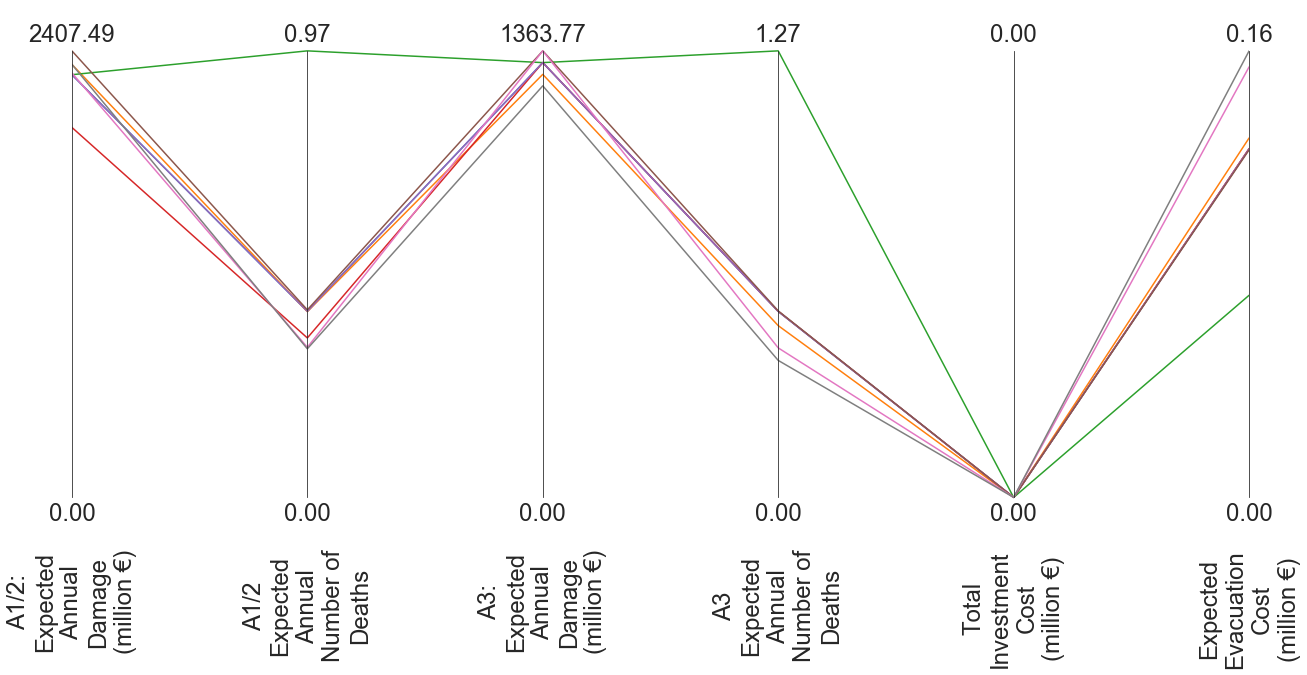

In [9]:
max_regret = pd.DataFrame()
single_regret = {}

for policy in np.unique(experiments['policy']): #loop x times for x different unique policies
    logical = experiments['policy']==policy #series of true/false for policy iteration
    for key in outcomes_df.keys(): #loop x times for each key in outcomes
        single_regret[key] = np.max(outcomes_df[key][logical])-np.min(outcomes_df[key][logical])
    max_regret = max_regret.append(pd.DataFrame(single_regret, index = [policy]))

data = max_regret
data['A1/2_EAD'] = data['A1/2_EAD'].apply(lambda x: x/1000000)
data['A3_EAD'] = data['A3_EAD'].apply(lambda x: x/1000000)
data['G_TIC'] = data['G_TIC'].apply(lambda x: x/1000000)
data['EEC'] = data['EEC'].apply(lambda x: x/1000000)

data.rename(columns={'A1/2_EAD':'A1/2:\nExpected\nAnnual\nDamage\n(million €)',
                     'A1/2_END':'A1/2\nExpected\nAnnual\nNumber of\nDeaths',
                     'A3_EAD':'A3:\nExpected\nAnnual\nDamage\n(million €)',
                     'A3_END':'A3\nExpected\nAnnual\nNumber of\nDeaths',
                     'G_TIC':'Total\nInvestment\nCost\n(million €)',
                     'EEC':'Expected\nEvacuation\nCost\n(million €)'}
            , inplace=True)

limits = parcoords.get_limits(data)
limits.loc[0, ['A1/2:\nExpected\nAnnual\nDamage\n(million €)', 
               'A1/2\nExpected\nAnnual\nNumber of\nDeaths', 
               'A3:\nExpected\nAnnual\nDamage\n(million €)', 
               'A3\nExpected\nAnnual\nNumber of\nDeaths', 
               'Total\nInvestment\nCost\n(million €)', 
               'Expected\nEvacuation\nCost\n(million €)',]] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=24)
paraxes.plot(data)
fig = plt.gcf()
fig.set_size_inches(24,16)
if remakeimages:
    plt.savefig('export/parcoords_maxregret.png', bbox_inches='tight')
plt.show()

**Interpretation:** for most policies, the regret is similar. The only one standing out is policy 3 (green), where the regret of number of deaths rises far above the others. Therefore this policy will not be taken into account.

The next robustness metric is signal to noise. This checks the deviation as a product to the mean to determine the quality of the policy. 

C:\Program Files (x86)\Anaconda\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


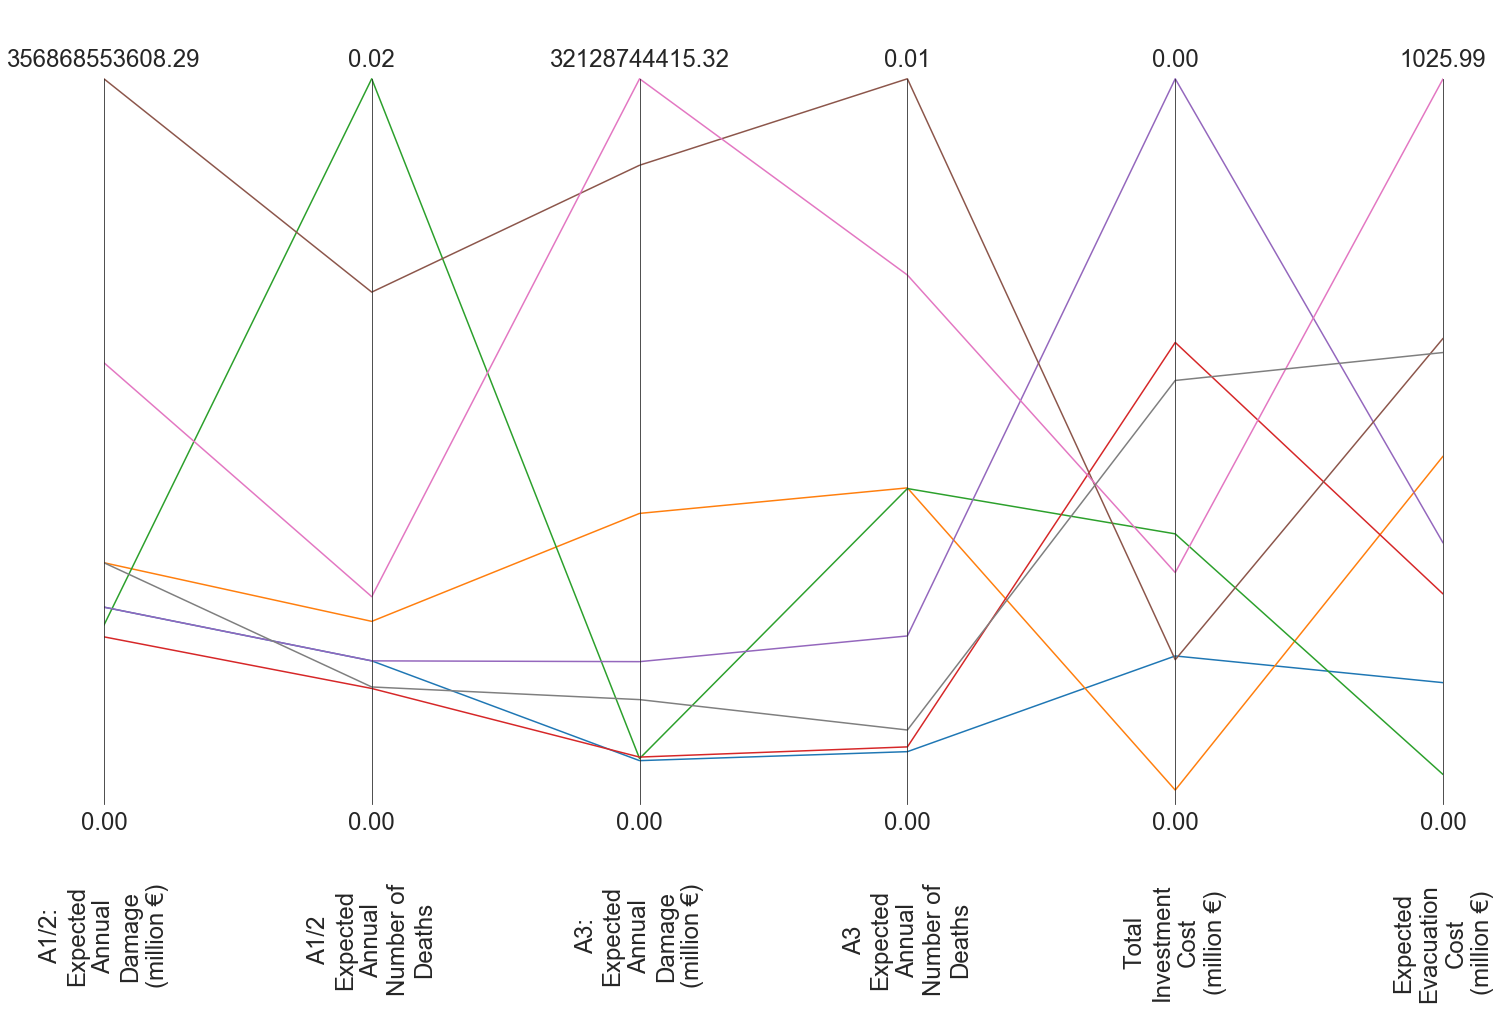

In [10]:
signal_to_noise = pd.DataFrame()
signal_single = {}

for policy in np.unique(experiments['policy']): #loop x times for x different unique policies
    logical = experiments['policy']==policy #series of true/false for policy iteration
    for key in outcomes_df.keys(): #loop x times for each key in outcomes
        signal_single[key] = np.mean(outcomes_df[key][logical])*np.std(outcomes_df[key][logical])
    signal_to_noise = signal_to_noise.append(pd.DataFrame(signal_single, index = [policy]))

data = signal_to_noise
data['A1/2_EAD'] = data['A1/2_EAD'].apply(lambda x: x/1000000)
data['A3_EAD'] = data['A3_EAD'].apply(lambda x: x/1000000)
data['G_TIC'] = data['G_TIC'].apply(lambda x: x/1000000)
data['EEC'] = data['EEC'].apply(lambda x: x/1000000)

data.rename(columns={'A1/2_EAD':'A1/2:\nExpected\nAnnual\nDamage\n(million €)',
                     'A1/2_END':'A1/2\nExpected\nAnnual\nNumber of\nDeaths',
                     'A3_EAD':'A3:\nExpected\nAnnual\nDamage\n(million €)',
                     'A3_END':'A3\nExpected\nAnnual\nNumber of\nDeaths',
                     'G_TIC':'Total\nInvestment\nCost\n(million €)',
                     'EEC':'Expected\nEvacuation\nCost\n(million €)'}
            , inplace=True)

limits = parcoords.get_limits(data)
limits.loc[0, ['A1/2:\nExpected\nAnnual\nDamage\n(million €)', 
               'A1/2\nExpected\nAnnual\nNumber of\nDeaths', 
               'A3:\nExpected\nAnnual\nDamage\n(million €)', 
               'A3\nExpected\nAnnual\nNumber of\nDeaths', 
               'Total\nInvestment\nCost\n(million €)', 
               'Expected\nEvacuation\nCost\n(million €)',]] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=24)
paraxes.plot(data)
fig = plt.gcf()
fig.set_size_inches(24,16)
if remakeimages:
    plt.savefig('export/parcoords_signaltonoise.png', bbox_inches='tight')
plt.show()

**Interpretation:** On this metric, the results vary more. Policies 6, 7 and 2 (brown, pink and orange) score worst on the signal to noise for damage and deaths.

Based on the two robustness metrics, policies 1, 4, 5 or 15 should be chosen. These both score similar on the robustness metrics. To make a choice between these two policies, the mean is compared.

C:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

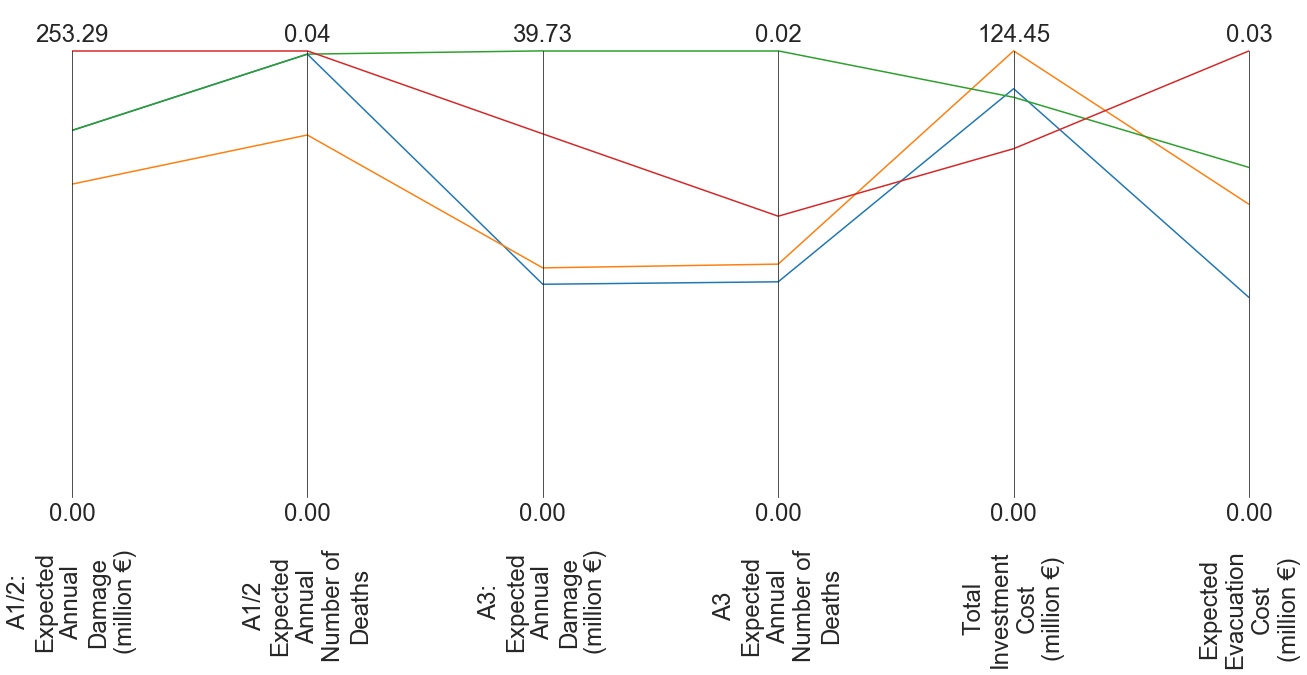

In [17]:
outcomes_mean = pd.DataFrame()
single_mean = {}

for policy in np.unique(experiments['policy']): #loop x times for x different unique policies
    logical = experiments['policy']==policy #series of true/false for policy iteration
    for key in outcomes_df.keys(): #loop x times for each key in outcomes
        single_mean[key] = np.mean(outcomes_df[key][logical])
    outcomes_mean = outcomes_mean.append(pd.DataFrame(single_mean, index = [policy]))
    
outcomes_filered = outcomes_mean.iloc[[0, 3, 4, 7],:]

data = outcomes_filered
data['A1/2_EAD'] = data['A1/2_EAD'].apply(lambda x: x/1000000)
data['A3_EAD'] = data['A3_EAD'].apply(lambda x: x/1000000)
data['G_TIC'] = data['G_TIC'].apply(lambda x: x/1000000)
data['EEC'] = data['EEC'].apply(lambda x: x/1000000)

data.rename(columns={'A1/2_EAD':'A1/2:\nExpected\nAnnual\nDamage\n(million €)',
                     'A1/2_END':'A1/2\nExpected\nAnnual\nNumber of\nDeaths',
                     'A3_EAD':'A3:\nExpected\nAnnual\nDamage\n(million €)',
                     'A3_END':'A3\nExpected\nAnnual\nNumber of\nDeaths',
                     'G_TIC':'Total\nInvestment\nCost\n(million €)',
                     'EEC':'Expected\nEvacuation\nCost\n(million €)'}
            , inplace=True)

limits = parcoords.get_limits(data)
limits.loc[0, ['A1/2:\nExpected\nAnnual\nDamage\n(million €)', 
               'A1/2\nExpected\nAnnual\nNumber of\nDeaths', 
               'A3:\nExpected\nAnnual\nDamage\n(million €)', 
               'A3\nExpected\nAnnual\nNumber of\nDeaths', 
               'Total\nInvestment\nCost\n(million €)', 
               'Expected\nEvacuation\nCost\n(million €)',]] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=24)
paraxes.plot(data)
fig = plt.gcf()
fig.set_size_inches(24,16)
if remakeimages:
    plt.savefig('export/parcoords_mean.png', bbox_inches='tight')
plt.show()

**Interpretation:** Policy 1 (blue) scores well on the means of expexted deaths and damage while keeping the investment cost relatively low. Therefore this will be the final proposed sollution.

In short:
Dike heightenings of 3, 2, 5, 8 and 2dm for dike rings 1 - 5 all in the first timestep, no room for the river and the early warning signal 2 days ahead.